<br />

<div style="text-align: center;">
<font size="6">ニューラルネットワーク・ディープラーニング p247 </font>
</div>
<br />
<div style="text-align: right;">
<font size="4"></font>
<br />
<font size="4"></font>
</div>

jupyterに慣れていない人への注意点

- 基本的に関数などは%resetをしない限り引き続くので，同じものを使う時は気を付ける．
- 前の文を編集してrunさせずに次の文(In[n])を走らせるとエラーが出る場合がある．
- コメント文を入れる時のスペースに気を付ける
- 式を書く時は＄ 式 ＄とすることで書くことができる．
- また下つき文字$X_i, x_2$ は，＄X＿i＄，＄x＿２＄と書くことでできる．

箇条書きは-を先頭につけるとかける．

# 7.1 ニューロンモデル

ニューロンモデル
- 脳の神経細胞をヒントを得て考案された数理モデル

入力 $x_0$, $x_1$ から以下を求める
- 入力総和 $a$ : 入力に重みをかけたものの総和
- 出力 $y$ : 入力総和 $a$ にシグモイド関数を通したもの

$y$ は 0 から 1 までの連続値をとり発火頻度を表す
- $a$ が大きいほど発火頻度が 1 に近づく 
- $a$ が負の大きい値ほど0に近づく

# 7.2 ニューラルネットワークモデル

ニューラルネットワークモデル
- ニューロンの集合体のモデル

今回は信号が一方向のみ流れるフィードフォワードニューラルネットを考える

# 7.2.2 2層フィードフォワードニューラルネットワークの実装

## 使用するデータの設定

In [1]:
#--  リスト 7-1-1(1)
import numpy as np

# データ生成 ------------------------------------------

np.random.seed(seed=1)  # 乱数を固定
N = 200 # データの数
K = 3 # 分布の数
T = np.zeros((N, 3), dtype=np.uint8)
X = np.zeros((N, 2))

X_range0 = [-3, 3] # X0 の範囲，表示用
X_range1 = [-3, 3] # X1 の範囲，表示用

Mu = np.array([[-.5, -.5], [.5, 1.0], [1, -.5]]) # 分布の中心
Sig = np.array([[.7, .7], [.8, .3], [.3, .8]]) # 分布の分散
Pi = np.array([0.4, 0.8, 1]) # 各分布への割合

for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T[n, k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T[n, :] == 1, k] + Mu[T[n, :] == 1, k]

## テストデータと訓練データに分割し保存

In [2]:
# リスト 7-1-(2)

# ------------ 2 分類のデータをテスト・訓練データに分割

TrainingRatio = 0.5

X_n_training = int(N * TrainingRatio)
X_train = X[:X_n_training, :]
X_test = X[X_n_training:, :]

T_train = T[:X_n_training, :]
T_test = T[X_n_training:, :]

# ------------- データを 'class_data.npz'  に保存
np.savez('class_data.npz', X_train=X_train, T_train=T_train, 
         X_test=X_test, T_test=T_test, 
         X_range0=X_range0, X_range1=X_range1)

## 図で確認してみる

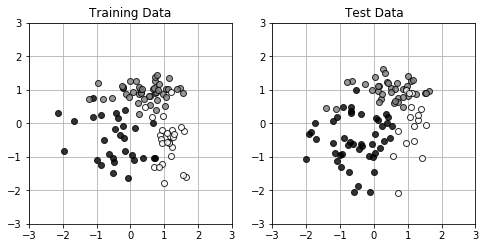

In [3]:
# リスト 7-1-(3)
import matplotlib.pyplot as plt
%matplotlib inline

# データの図示 -----------------------------------------

def Show_data(x, t):
      
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1], 
                 linestyle = 'none', marker = 'o', markeredgecolor='black', 
                 color=c[i], alpha=0.8)
    plt.grid(True)
    
# メイン --------------------------------------------------

plt.figure(1, figsize=(8, 3.7))

plt.subplot(1, 2, 1)
Show_data(X_train, T_train)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Training Data')

plt.subplot(1, 2, 2)
Show_data(X_test, T_test)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.title('Test Data')

plt.show()

左に訓練データ，右にテストデータが表示されている

## 2層のフィードフォワードニューラルネットワークを FNN として定義して実装を行う

In [4]:
# リスト 7-1-(4)

# シグモイド関数 -------------------------------------------------------
def Sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y

# ネットワーク ----------------------------------------------------------
def FNN(wv, M, K, x):
    N, D = x.shape # 入力次元
    
    w = wv[:M * (D+1)] # 中間層ニューロンへの重み
    w = w.reshape(M, (D + 1))
    v = wv[M * (D+1):] # 出力層ニューロンへの重み
    v = v.reshape((K, M+1))
    
    b = np.zeros((N, M + 1)) # 中間層ニューロンの入力総和
    z = np.zeros((N, M + 1)) # 中間層ニューロンの出力
    a = np.zeros((N, K)) # 出力層ニューロンの入力総和
    y = np.zeros((N, K)) # 出力層ニューロンの出力
    
    for n in range(N):
        # 中間層の計算
        for m in range(M):
            b[n, m] = np.dot(w[m, :], np.r_[x[n, :], 1]) # (A)
            z[n, m] = Sigmoid(b[n, m])
            
        # 出力層の計算
        z[n, M] = 1 # ダミーニューロン
        wkz = 0
        for k in range(K):
            a[n, k] = np.dot(v[k, :], z[n, :])
            wkz = wkz + np.exp(a[n, k])
        for k in range(K):
            y[n, k] = np.exp(a[n, k]) / wkz
        
    return y, a, z, b
    
# test ---
WV = np.ones(15)
M = 2
K = 3
FNN(WV, M, K, X_train[:2, :])

(array([[0.33333333, 0.33333333, 0.33333333],
        [0.33333333, 0.33333333, 0.33333333]]),
 array([[2.6971835 , 2.6971835 , 2.6971835 ],
        [1.49172649, 1.49172649, 1.49172649]]),
 array([[0.84859175, 0.84859175, 1.        ],
        [0.24586324, 0.24586324, 1.        ]]),
 array([[ 1.72359839,  1.72359839,  0.        ],
        [-1.12079826, -1.12079826,  0.        ]]))

- $W$ は中間層の重み，$V$ は出力層の重み

- wv は $W$ と $V$ をひとまとめにしたベクトル

- np.r_[A , B] は行列を横に連結させるという命令

# 7.2.3 数値微分法

## 2層フィードフォワードニューラルネットワークに3分類問題を解かせる
- 誤差関数として平均交差エントロピー誤差を使用

## CE_FNNという関数で平均交差エントロピー誤差を実装

In [5]:
# リスト 7-1-(5)

# 平均交差エントロピー誤差 -------------
def CE_FNN(wv, M, K, x, t):
    N, D = x.shape
    y, a, z, b = FNN(wv, M, K, x)
    ce = -np.dot(t.reshape(-1), np.log(y.reshape(-1))) / N
    return ce

# test ---
WV = np.ones(15)
M = 2
K = 3
CE_FNN(WV, M, K, X_train[:2, :], T_train[:2, :])

1.0986122886681098

以下の流れで計算している
- 入力データ $x$ と目標データ $t$ を入力
- $x$ から FNN が $y$ を出力
- $y$ と $t$ を比べて交差エントロピーを求める

## CE_FNN の数値微分を出力する関数 dCE_FNN_num を実装

[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


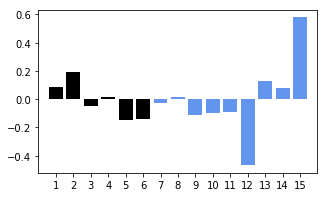

In [6]:
# リスト 7-1-(6)

# - 数値計算 --------------------------------------
def dCE_FNN_num(wv, M, K, x, t):
    epsilon = 0.001
    dwv = np.zeros_like(wv)
    for iwv in range(len(wv)):
        wv_modified = wv.copy()
        wv_modified[iwv] = wv[iwv] - epsilon
        mse1 = CE_FNN(wv_modified, M, K, x, t)
        wv_modified[iwv] = wv[iwv] + epsilon
        mse2 = CE_FNN(wv_modified, M, K, x, t)
        dwv[iwv] = (mse2 - mse1) / (2 * epsilon)
    
    return dwv


# -- dWVの表示 --------------------------------------
def Show_WV(wv, M):
    N = wv.shape[0]
    plt.bar(range(1, M * 3 + 1), wv[:M * 3], align="center", color='black')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:],
           align="center", color='cornflowerblue')
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)
    
# - test--------------------------------------------------
M = 2
K = 3
nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)
dWV = dCE_FNN_num(WV, M, K, X_train[:2, :], T_train[:2, :])
print(dWV)
plt.figure(1, figsize=(5, 3))
Show_WV(dWV, M)
plt.show()

M = 2, K = 3 のとき wv の長さは 2 × 2 + 3 × 3 = 15 である

棒グラフは15個の重みパラメータそれぞれに対する数値偏微分値を表している

黒の部分が $W$, 青の部分が $V$ 

# 7.2.4 数値微分法による勾配法

CE_FNN や dCE_FNN_num を使って勾配法を適用し，分類問題を解く

## Fit_FNN_num の実装

入力
- 重みの初期値 : wv_init
- 訓練データ
- テストデータ

出力
- 最適化されたパラメータ : wv

その他変数
- 学習ステップ数 : n
- 学習定数 : alpha

In [7]:
# リスト 7-1-(7)
import time

# 数値微分を使った勾配法 ------------------------------
def Fit_FNN_num(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wv = wv_init
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    
    for i in range(n): # (A)
        wv = wv - alpha * dCE_FNN_num(wv, M, K, x_train, t_train)
        err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
        wv_hist[i, :] = wv
        
    return wv, wv_hist, err_train, err_test


# メイン ----------------------------------------------------
startTime = time.time()
M = 2
K = 3
np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))
N_step = 1000 # (B) 学習ステップ
alpha = 0.5
WV, WV_hist, Err_train, Err_test = Fit_FNN_num(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)
calculation_time = time.time() - startTime

print("Calculation time : {0: .3f} sec".format(calculation_time))

Calculation time :  182.304 sec


## 図による誤差の表示

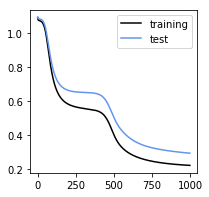

In [8]:
# リスト 7-1-(8)

# 学習誤差の表示 ----------------------------------------------------------
plt.figure(1, figsize=(3, 3))
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label = 'test')
plt.legend()
plt.show()

縦軸が誤差を表しており，単調的に減少していることがわかる

400 ステップ辺りで学習が収束したように見えるが，そこからまた急激に変化している(学習が進んでいる)

なぜだろう?

## 重みの時間発展の表示

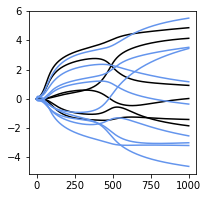

In [9]:
# リスト 7-1-(9)

# 重みの時間発展の表示 ------------------------------------------------------
plt.figure(1, figsize=(3, 3))
plt.plot(WV_hist[:, :M * 3], 'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')
plt.show()

- 黒の部分が $W$, 青の部分が $V$ 
- 0 周辺からスタートした重みが何らかの値に収束しようとしていることがわかる
- よくみると，400 ステップ付近でそれぞれの重みのグラフが交差していることがわかる

このことから，誤差関数の勾配の方向が変化したことがわかる

## クラスの境界線の表示

- 重みパラメータ wv を渡す
- 表示する入力空間を 60 × 60 に分割する
- 得られる領域を，等高線で表示

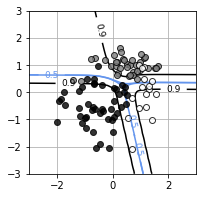

In [10]:
# リスト 7-1-(10)

# 境界線表示関数 ------------------------------------------------------------------
def show_FNN(wv, M, K):
    xn = 60 # 等高線表示の解像度
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
    y, a, z, b = FNN(wv, M, K, x)
    plt.figure(1, figsize=(4, 4))
    for ic in range(K):
        f = y[:, ic]
        f = f.reshape(xn, xn)
        f = f.T
        cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9],
                          colors=['cornflowerblue', 'black'])
        cont.clabel(fmt='%.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)

# 境界線の表示 --------------------------------------------------------------------------
plt.figure(1, figsize=(3, 3))
Show_data(X_test, T_test)
show_FNN(WV, M, K)
plt.show()

テストデータ上でも，うまく境界線が引けていることが確認できる

## 7.2.8 誤差逆伝播法の実装

誤差逆伝播法
- ネットワークの出力で生じる誤差(教師信号との誤差)を使用
- 出力層の重み $v_{k,j}$ から 中間層への重み $w_{j,i}$ を更新していく(改善していく)

analytical dWV
[ 0.08848131  0.19158    -0.051398    0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115649 -0.10104422 -0.09427964 -0.46855604
  0.13096434  0.08076649  0.57971253]
numerical dWV
[ 0.0884813   0.19157999 -0.05139799  0.01281536 -0.14468029 -0.14242768
 -0.02992012  0.01351315 -0.11115648 -0.10104422 -0.09427964 -0.46855603
  0.13096434  0.08076649  0.57971252]


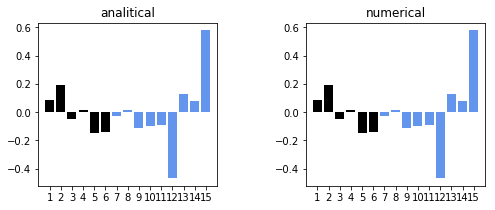

In [11]:
# リスト 7-1-(11)

# 解析的微分 ------------------------------------------------------------------------------
def dCE_FNN(wv, M, K, x, t):
    N, D = x.shape
    
    # wv を w と v に戻す
    w = wv[:M * (D+1)]
    w = w.reshape(M, (D + 1))
    v = wv[M * (D+1):]
    v = v.reshape((K, M+1))
    
    # 1. x を入力して y を得る
    y, a, z, b = FNN(wv, M, K, x)
    
    # 出力変数の準備
    dwv = np.zeros_like(wv)
    dw = np.zeros((M, D+1))
    dv = np.zeros((K, M+1))
    delta1 = np.zeros(M) # 1層目誤差
    delta2 = np.zeros(K) # 2層目誤差 (K=0 の部分は使わず)
    
    for n in range(N):
        # 2. 出力層の誤差を求める
        for k in range(K):
            delta2[k] = (y[n, k] - t[n, k])
            
        # 3. 中間層の誤差を求める
        for j in range(M):
            delta1[j] = z[n, j] * (1 - z[n, j]) * np.dot(v[:, j], delta2)
        
        # 4.  v の勾配 dv を求める
        for k in range(K):
            dv[k, :] = dv[k, :] + delta2[k] * z[n, :] / N
            
        # 4. w の勾配 dw を求める
        for j in range(M):
            dw[j, :] = dw[j, :] + delta1[j] * np.r_[x[n, :], 1] / N
            
    # dw と dv を合体させて dwv とする
    dwv = np.c_[dw.reshape((1, M * (D + 1))),  dv.reshape((1, K * (M + 1)))]
    dwv = dwv.reshape(-1)
    
    return dwv
    
# ------------- Show dWV
def Show_dWV(wv, M):
    N = wv.shape[0]
    
    plt.bar(range(1, M * 3 + 1), wv[:M * 3], align = "center", color = 'black')
    plt.bar(range(M * 3 + 1, N + 1), wv[M * 3:], align = "center", color = 'cornflowerblue')
    
    plt.xticks(range(1, N + 1))
    plt.xlim(0, N + 1)
    
# --- 動作確認
M = 2
K = 3
N = 2

nWV = M * 3 + K * (M + 1)
np.random.seed(1)
WV = np.random.normal(0, 1, nWV)

dWV_ana = dCE_FNN(WV, M, K, X_train[:N, :], T_train[:N, :])
print("analytical dWV")
print(dWV_ana)

dWV_num = dCE_FNN_num(WV, M, K, X_train[:N, :], T_train[:N, :])
print("numerical dWV")
print(dWV_num)

plt.figure(1, figsize=(8, 3))
plt.subplots_adjust(wspace=0.5)
plt.subplot(1, 2, 1)
Show_dWV(dWV_ana, M)
plt.title('analitical')
plt.subplot(1, 2, 2)
Show_dWV(dWV_num, M)
plt.title('numerical')
plt.show()

左の図が解析的微分値(dWV_ana)，右の図が上で作成した数値微分の値(dWV_num)

- 数値微分の値とほぼ一致していることが分かる
- 正しく計算できることが確認できた

次に，数値微分で解いた分類問題を誤差逆伝播法で解いてみる

## 誤差逆伝播法で分類問題を解く

In [13]:
# リスト 7-1-(12)

# 解析的微分を使った勾配法 --------------------------------------------------------
def Fit_FNN(wv_init, M, K, x_train, t_train, x_test, t_test, n, alpha):
    wv = wv_init.copy()
    err_train = np.zeros(n)
    err_test = np.zeros(n)
    wv_hist = np.zeros((n, len(wv_init)))
    for i in range(n):
        wv = wv - alpha * dCE_FNN(wv, M, K, x_train, t_train) # (A)
        err_train[i] = CE_FNN(wv, M, K, x_train, t_train)
        err_test[i] = CE_FNN(wv, M, K, x_test, t_test)
        wv_hist[i, :] = wv
    return wv, wv_hist, err_train, err_test

# メイン
startTime = time.time()

M = 2
K = 3

np.random.seed(1)
WV_init = np.random.normal(0, 0.01, M * 3 + K * (M + 1))

N_step = 1000
alpha = 0.5

WV, WV_hist, Err_train, Err_test = Fit_FNN(
    WV_init, M, K, X_train, T_train, X_test, T_test, N_step, alpha)

calculation_time = time.time() - startTime
print("Calculation time : {0: .3f} sec".format(calculation_time))
        

Calculation time :  23.055 sec


- 作業としては上の Fit_FNN_num での dCE_FNN_num の部分を dCE_FNN に変えるだけ (A)


- 数値微分に比べてかなり早く計算できる
- 私の PC だと約8倍になった
- 嬉しいですね

## 図の表示による確認

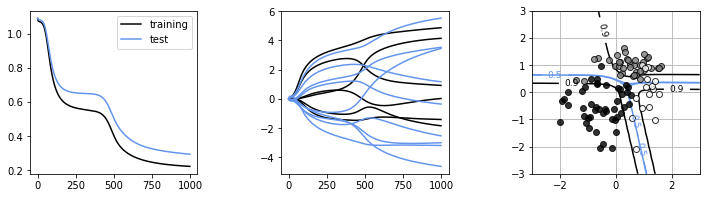

In [14]:
# リスト 7-1-(13)

plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)

# 学習誤差の表示 -------------------------------------------------------------
plt.subplot(1, 3, 1)
plt.plot(Err_train, 'black', label='training')
plt.plot(Err_test, 'cornflowerblue', label='test')
plt.legend()

# 重みの時間発展の表示 -----------------------------------------------------
plt.subplot(1, 3, 2)
plt.plot(WV_hist[:, :M * 3],  'black')
plt.plot(WV_hist[:, M * 3:], 'cornflowerblue')

# 境界線の表示 ---------------------------------------------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)

M = 2
K = 3
show_FNN(WV, M, K)
plt.show()

数値微分のときと同じ結果を得られた


- 数値微分は導出した微分の式が正しいかチェックする強力なツール

- 新しい誤差関数の微分の式を求める必要があるときは，まず初めに数値微分で正しい値を出しておくことがおすすめ

## プログラムのまとめ

- X_train と T_train (訓練データ)で wv を学習
- X_test と T_test (テストデータ)で評価
- 交差エントロピーを小さくする wv を求めるために以下を使用
    - 交差エントロピーを求める CE_FNN とその微分 dCE_FNN 
    - 両方の関数の中でネットワークの出力 FNN 
    - FNN の中では活性化関数 Sigmoid 

## 7.2.9  学習後のニューロンの特性

なぜ2層ネットワークが上の右図のように曲線の境界を表示できたのだろう？

各ニューロン $b_j$, $z_j$, $a_k$, $y_k$ の特性を図示してみよう 

## 図示によるニューロン特性の確認

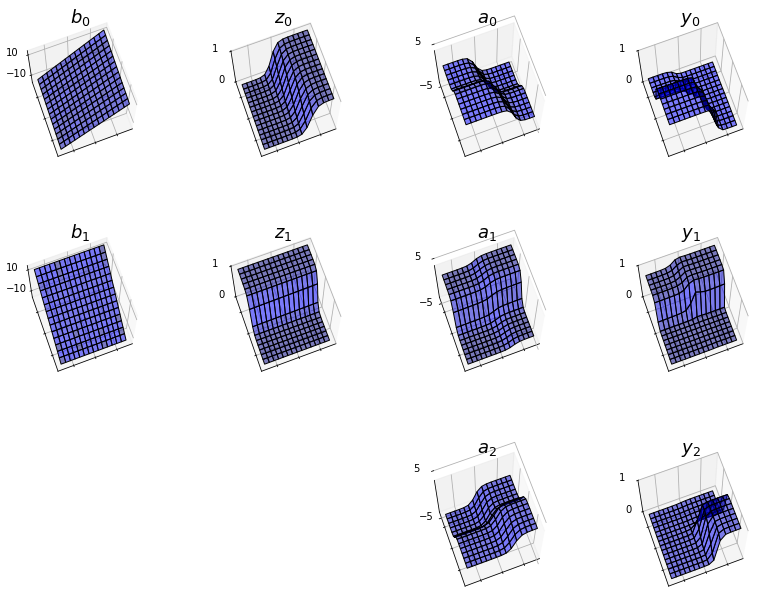

In [15]:
# リスト 7-1-(14)
from mpl_toolkits.mplot3d import Axes3D

def show_activation3d(ax, v, v_ticks, title_str):
    f = v.copy()
    f = f.reshape(xn, xn)
    f = f.T
    ax.plot_surface(xx0, xx1, f, color='blue', edgecolor='black',
                  rstride=1, cstride=1, alpha=0.5)
    ax.view_init(70, -110)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticks(v_ticks)
    ax.set_title(title_str, fontsize=18)
    
M = 2
K = 3
xn = 15 # 等高線表示の解像度
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
y, a, z, b = FNN(WV, M, K, x)

fig = plt.figure(1, figsize=(12, 9))
plt.subplots_adjust(left=0.075, bottom = 0.05, right=0.95,
                   top = 0.95, wspace=0.4, hspace=0.4)
for m in range(M):
    ax = fig.add_subplot(3, 4, 1 + m * 4, projection='3d')
    show_activation3d(ax, b[:, m], [-10, 10], '$b_{0:d}$'.format(m))
    ax = fig.add_subplot(3, 4, 2 + m * 4, projection='3d')
    show_activation3d(ax, z[:, m], [0, 1], '$z_{0:d}$'.format(m))

for k in range(K):
    ax = fig.add_subplot(3, 4, 3 + k * 4, projection='3d')
    show_activation3d(ax, a[:, k], [-5, 5], '$a_{0:d}$'.format(k))
    ax = fig.add_subplot(3, 4, 4 + k * 4, projection='3d')
    show_activation3d(ax, y[:, k], [0, 1], '$y_{0:d}$'.format(k))
    

上の図は様々な入力 $x_0$, $x_1$ の場合の各変数を表している 

- 中間層の入力総和 $b_j$ は入力 $x_i$ の線形和なので平面になっている
- シグモイド関数 $\sigma()$ をくぐることによって $b_j$ の低い部分と高い部分に分かれて 0-1 の出力 $z_j$ になる


- $a_k$ は $z_0$ と $z_1$ の線形和で作られている
- 図をみると $a_0$ と $a_1$ は $z_0$ と $z_1$ を組み合わせたものだと分かる


- $y_k$ は $a$ をソフトマックス関数で 0~1 の範囲に圧縮されて作られている
- $y_0$ と $y_1$ と $y_2$ の面を全て足し合わせると高さが1の平面になる


イメージできたでしょうか？

# Keras でニューラルネットワークモデル

- この節では TensorFlow および Keras を使用します．

- これらを使うことによって大規模なニューラルネットワークが比較的短いコードで実装できかつ高速で動かすことができます．


- Keras および TensorFlow は一章を参照してインストールを行ってください．

- それぞれのバージョンは教科書のものに合わせた方が良いです(最新のものだと動かないことがありました)．

In [16]:
import keras

Using TensorFlow backend.


こんな感じになってると OK

In [17]:
keras.__version__

'2.2.4'

同じバージョンがおすすめです.

   # 7.3.1 2層フィードフォワードニューラルネット

### Keras で上と同じ，3分類問題を解く二層フィードフォワードネットワークを作って動かしてみる

まずメモリのリセットを行う

- 変数や関数などの初期化

In [18]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


なんかいっぱいエラーが出ますが大丈夫です．

## 必要なライブラリの import  とデータの load

- 初期化されているのでライブラリを再 import

- リスト 7-1-(2) で保存していたデータから load 

In [19]:
# リスト 7-2-(1)
import numpy as np
import matplotlib.pyplot as plt
import time

import tensorflow as tf

np.random.seed(1) # (A)
import keras.optimizers #  (B)
from keras.models import Sequential # (C)
from keras.layers.core import Dense, Activation # (D)



# データの load -----------------------------------------------
outfile = np.load('class_data.npz')
X_train = outfile['X_train']
T_train = outfile['T_train']
X_test = outfile['X_test']
T_test = outfile['T_test']
X_range0 = outfile['X_range0']
X_range1 = outfile['X_range1']

(B),(C),(D) は Keras 関係のライブラリの import

(A) は Keras 内で使われる乱数をリセットするためのコードで実行するたび同じ結果が得られます

## 図示のための関数の再定義

関数も初期化されているので再定義を行いましょう

In [20]:
# リスト 7-2-(2)
# データの図示 -------------------------------------------------
def Show_data(x, t):
    wk, n = t.shape
    c = [[0, 0, 0], [.5, .5, .5], [1, 1, 1]]
    for i in range(n):
        plt.plot(x[t[:, i] == 1, 0], x[t[:, i] == 1, 1],
                linestyle='none', marker='o',
                markeredgecolor='black',
                color=c[i], alpha=0.8)
        plt.grid(True)

## Keras を使った2層フィードフォワードニューラルネットワークモデルの作成

In [22]:
# リスト 7-2-(3)

# 乱数の初期化
np.random.seed(1)

# --- Sequential モデルの作成
model = Sequential()

model.add(Dense(2, input_dim=2, activation='sigmoid',
                kernel_initializer='uniform')) # (A)
model.add(Dense(3, activation='softmax',
               kernel_initializer='uniform')) # (B)
sgd = keras.optimizers.SGD(lr=0.5, momentum=0.0,
                          decay=0.0, nesterov=False) # (C)
model.compile(optimizer=sgd, loss='categorical_crossentropy',
             metrics=['accuracy']) # (D)

# ------------- 学習
startTime = time.time()
history = model.fit(X_train, T_train, epochs=1000, batch_size=100,
                   verbose=0, validation_data=(X_test, T_test)) # (E)

# -------------- モデル
score = model.evaluate(X_test, T_test, verbose=0) # (F)
print('cross entropy {0: .2f}, accuracy {1: .2f}'.format(score[0], score[1]))

calculation_time = time.time() - startTime
print("Calculation time:{0: .3f} sec".format(calculation_time))


cross entropy  0.30, accuracy  0.88
Calculation time: 1.505 sec


- 7.2 節で作成した機能がこの短いプログラムで実現できている


- 交差エントロピー誤差が 0.30 ，正答率が 0.88
- 計算時間が上で作成した誤差逆伝播法や数値微分法に比べてかなり早くなっていることが分かる
- Keras は非常に便利だといえる

## 学習過程と結果の表示

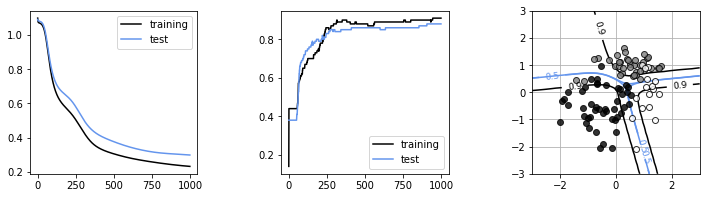

In [23]:
# リスト 7-2-(4)
plt.figure(1, figsize=(12, 3))
plt.subplots_adjust(wspace=0.5)

# 学習曲線表示 -------------------------------------------------
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], 'black', label='training') # (A)
plt.plot(history.history['val_loss'], 'cornflowerblue', label='test') # (B)
plt.legend()

# 精度表示 -------------------------------------------------------
plt.subplot(1, 3, 2)
plt.plot(history.history['acc'], 'black', label='training') # (C)
plt.plot(history.history['val_acc'], 'cornflowerblue', label='test') # (D)
plt.legend()

# 境界線表示 ----------------------------------------------------
plt.subplot(1, 3, 3)
Show_data(X_test, T_test)
xn = 60 # 等高線表示の解像度
x0 = np.linspace(X_range0[0], X_range0[1], xn)
x1 = np.linspace(X_range1[0], X_range1[1], xn)
xx0, xx1 = np.meshgrid(x0, x1)
x = np.c_[np.reshape(xx0, xn * xn, 1), np.reshape(xx1, xn * xn, 1)]
y = model.predict(x) # (E)
K = 3 

for ic in range(K):
    f = y[:, ic]
    f = f.reshape(xn, xn)
    f = f.T
    cont = plt.contour(xx0, xx1, f, levels=[0.5, 0.9], colors=['cornflowerblue', 'black'])
    cont.clabel(fmt='%.1f', fontsize=9)
    plt.xlim(X_range0)
    plt.ylim(X_range1)
plt.show()

データの参照
- history.history['loss'] → 訓練データの交差エントロピー誤差 (A)
- history.history['val_loss'] → テストデータデータの交差エントロピー誤差 (B)
- history.history['acc'] → 訓練データの正答率 (C)
- history.history['val_acc'] → テストデータの正答率 (D)


それぞれの図について
- 左図
    - 訓練データの誤差が速やかに減少していることがわかる 
    - テストデータの誤差も増加していないことからオーバーフィッティングが起きていないことがわかる


- 真ん中の図
    - 訓練データとテストデータの正答率を示している
    - 学習が上手くいっていれば 1 に近づく
    - ただし，目的関数とは異なるので減少することもある


- 右図
    - 学習したモデルが 7.2 節のモデルと同様にカテゴリー間の境界を表していることがわかる
    

以上で Keras を使用してこれまでのモデルと変わらずに学習させることができた.